<a href="https://colab.research.google.com/github/gmazzitelli/studenti/blob/master/show_image_online_root.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code load ROOT, python 2 environment. Runs this part only the first time.

In [1]:
import sys
print (sys.version, get_ipython())
if 'google.colab' in str(get_ipython()) and sys.version[0:1] in '2':
  print('Running on CoLab')

  # istallazione di ROOT dal CERN
  !mkdir -p APPS
  !pwd
  !cd APPS && wget --no-check-certificate https://root.cern.ch/download/root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz 
  !cd APPS && tar -xf root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz

  base_lib_path = '/content/APPS/root/lib/'
  # main paths for ROOT  
  import sys
  sys.path.append(base_lib_path)
  import ctypes
  sys.path.append(base_lib_path)
  ctypes.cdll.LoadLibrary(base_lib_path+'libCore.so')
  ctypes.cdll.LoadLibrary(base_lib_path+'libThread.so')
  ctypes.cdll.LoadLibrary(base_lib_path+'libImt.so')
  ctypes.cdll.LoadLibrary(base_lib_path+'libRIO.so')
  ctypes.cdll.LoadLibrary(base_lib_path+'libNet.so')
  ctypes.cdll.LoadLibrary(base_lib_path+'libTree.so')
  ctypes.cdll.LoadLibrary(base_lib_path+'libMathCore.so')
  ctypes.cdll.LoadLibrary(base_lib_path+'libMatrix.so')
  ctypes.cdll.LoadLibrary(base_lib_path+'libHist.so')
  ctypes.cdll.LoadLibrary(base_lib_path+'libGraf.so')
  # itsllation and root-numpy main PATH
  !pip install root-numpy
  ctypes.cdll.LoadLibrary(base_lib_path+'libMultiProc.so')
  ctypes.cdll.LoadLibrary(base_lib_path+'libGpad.so')
  ctypes.cdll.LoadLibrary(base_lib_path+'libGraf3d.so')
  ctypes.cdll.LoadLibrary(base_lib_path+'libTreePlayer.so')
  # patch to open online FILE
  ! sudo apt-get install libdavix0v5
  ctypes.cdll.LoadLibrary(base_lib_path+'libRDAVIX.so')
  ! echo "Davix.GSI.CACheck: n" >> $ROOTSYS/etc/system.rootrc
  ! cp $ROOTSYS/etc/system.rootrc $HOME/.rootrc
  ! tail -1 $HOME/.rootrc
  ! pip install -q  python-swiftclient
  ! pip install -q  keystoneauth1
  ! pip install -q  h5py
  ! rm cygnus_lib.*; rm mylib.*
  ! wget https://raw.githubusercontent.com/gmazzitelli/cygno/master/cygnus_lib.py
  ! wget https://raw.githubusercontent.com/gmazzitelli/cygno/master/mylib.py
  sys.path.append('.')
  ! mkdir -p data
else:
  print ("non ho fatto nulla ;) non sono su Colab!")

('2.7.17 (default, Feb 27 2021, 15:10:58) \n[GCC 7.5.0]', <google.colab._shell.Shell object at 0x7fbd8880cb50>)
Running on CoLab
/content
--2021-03-22 18:30:02--  https://root.cern.ch/download/root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz
Resolving root.cern.ch (root.cern.ch)... 137.138.18.236, 2001:1458:201:ee::100:6
Connecting to root.cern.ch (root.cern.ch)|137.138.18.236|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137415272 (131M) [application/x-gzip]
Saving to: ‘root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz’

root_v6.13.08.Linux 100%[===================>] 131.05M  99.2MB/s    in 1.3s    

2021-03-22 18:30:04 (99.2 MB/s) - ‘root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz’ saved [137415272/137415272]

     |████████████████████████████████| 522kB 12.3MB/s 
  Created wheel for root-numpy: filename=root_numpy-4.8.0-cp27-cp27mu-linux_x86_64.whl size=1075541 sha256=b40915a44a43704571538a80910b0efbcb81651356eb04beb9a44606b17dce13
  Stored in directo

richima paccehtti python per CYGNO


In [2]:
import sys
import matplotlib.pyplot as plt
import numpy as np    
import ROOT
import root_numpy as rtnp

import cygnus_lib as cy
import mylib as my
%matplotlib inline
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import scipy.stats as stats
from itertools import combinations
import math
import os

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
cy.set_atlas_style('square')

Welcome to JupyROOT 6.13/08


In [16]:
def ped_(run, path='./', tag = 'LAB', min_image_to_read = 0, max_image_to_read = 0):
    #
    # run numero del run
    # path path lettura/scrittura piedistalli
    # tag subdirectory dei dati
    # min_image_to_read , max_image_to_read  range di imagine sul quale fare i piedistalli 
    # max_image_to_read = 0 EQUIVALE A TUTTE LE IMMAGINI
    #
    import ROOT
    import root_numpy as rtnp
    import numpy as np
    import cygnus_lib as cy
    # funzione per fare i piedistalli se gia' non esistino nella diretory
    fileoutm = (path+"run%d_mean.h5" % (run))
    fileouts = (path+"run%d_sigma.h5" % (run))
    try: 
        # i file gia' esistono
        m_image = cy.read_image_h5(fileoutm)
        s_image = cy.read_image_h5(fileouts)
        return m_image, s_image
    except:
        # i file non esistono crea il file delle medie e delle sigma per ogni pixel dell'immagine
        print (">>> Pedestal Maker! <<<")
        try:
            
            print ('Open file: '+cy.swift_root_file(tag, run))
            f=ROOT.TFile.Open(cy.swift_root_file(tag, run))
            print ('Find Keys: '+str(len(f.GetListOfKeys())))
            pic, wfm = cy.root_TH2_name(f)
            max_image = len(pic)
            max_wfm = len(wfm)
            image = rtnp.hist2array(f.Get(pic[0])).T
            x_resolution = image.shape[1]
            y_resolution = image.shape[0]
            print ("# of Images (TH2) Files: %d " % (max_image))
            print ("# of Waveform (TH2) Files: %d " % (max_wfm))

        except:
            print ("ERROR: No file %d" % (run))
            return
        if max_image_to_read == 0:
            max_image_to_read=max_image 
        print ("WARNING: pdestal from %d to %d" % (min_image_to_read, max_image_to_read))

        m_image = np.zeros((x_resolution, y_resolution), dtype=np.float64)
        s_image = np.zeros((x_resolution, y_resolution), dtype=np.float64)

        n0 = 0
        for iTr in range(min_image_to_read, max_image_to_read):
            image = rtnp.hist2array(f.Get(pic[iTr])).T
            m_image += image
            s_image += image**2 
            if n0 > 0 and n0 % 10==0:  # print progress and debung info for poit 200, 200...
                print ("Debug Image[200,200]: %d => %.2f %.2f %.2f " % (iTr,
                                                image[200,200],
                                                np.sqrt((s_image[200,200] - 
                                                        m_image[200,200]**2 
                                                          / (n0+1)) / n0),
                                                m_image[200,200]/(n0+1),
                                                ))
            n0 += 1
        m_image = m_image/n0
        s_image = np.sqrt((s_image - m_image**2 * n0) / (n0 - 1))

        ###### print Info and Save OutPut ######################################

        print ("sigma %f" % (s_image[200,200]))
        cy.write_image_h5(fileoutm, m_image)
        cy.write_image_h5(fileouts, s_image)
        print("DONE OUTPUT on files: %s, %s", (fileoutm, fileouts))
        return m_image, s_image

In [17]:
!rm run3965_mean.h5 run3965_sigma.h5

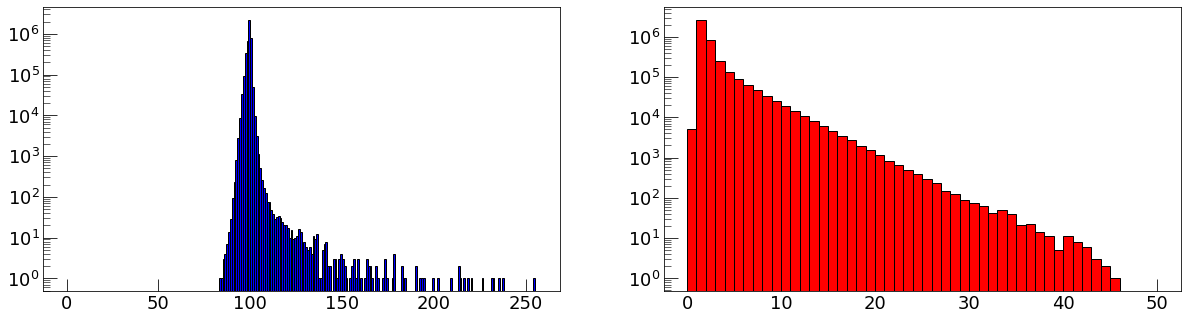

In [20]:
m_image, s_image = ped_(3965)
cy.set_atlas_style('long')
fig, ax = plt.subplots(1,2)
ax[0].hist(m_image.ravel(), bins=256, range=(0.0, 256.0), fc='b', ec='k')
ax[1].hist(s_image.ravel(), bins=50, range=(0.0, 50.0), fc='r', ec='k')
ax[0].set_yscale("log")
ax[1].set_yscale("log")
plt.show()
# imagem = cy.read_image_h5('run3965_mean.h5')
# plt.imshow(m_image, vmin=95, vmax=130)
# plt.show()

apere file [rum] from [tag] 

In [21]:
run = 3957
tag = "LAB" # Run tag: MAN, FNG, LAB, BTF, LTD
print ('Open file: '+cy.swift_root_file(tag, run))
f = ROOT.TFile.Open(cy.swift_root_file(tag, run))
print ('Find Keys: '+str(len(f.GetListOfKeys())))
pic, wfm = cy.root_TH2_name(f)
max_image = len(pic)
max_wfm = len(wfm)
print ("# of Images (TH2) Files: {:d}".format(max_image))
print ("# of Waveform (TH2) Files: {:d} ".format(max_wfm))
image = rtnp.hist2array(f.Get(pic[0])).T
x_resolution = image.shape[1]
y_resolution = image.shape[0]
print ('Camera X, Y pixel: {:d} {:d} '.format(x_resolution, y_resolution))

Open file: https://swift.cloud.infn.it:8080/v1/AUTH_1e60fe39fba04701aa5ffc0b97871ed8/Cygnus/Data/LAB/histograms_Run03957.root
Find Keys: 100
# of Images (TH2) Files: 100
# of Waveform (TH2) Files: 0 
Camera X, Y pixel: 2048 2048 


show imege file from [ini] to [end]

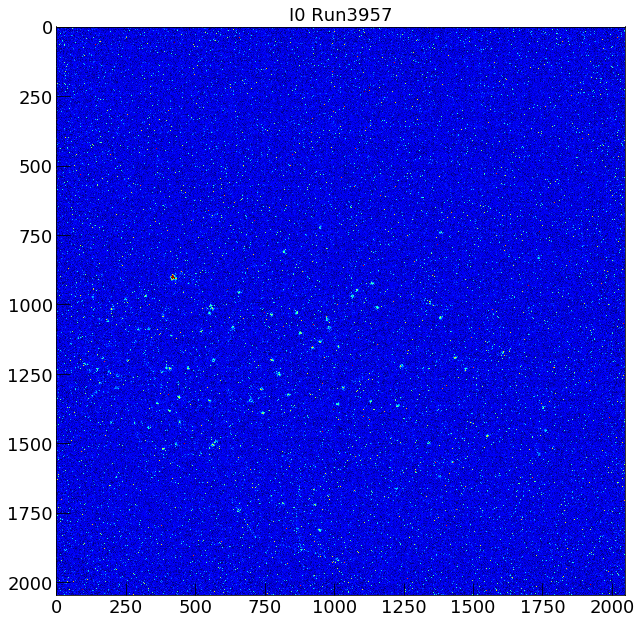

In [23]:
iTr = 0 # numero imagine da leggere
save = False
image = rtnp.hist2array(f.Get(pic[iTr])).T
fig = plt.figure(figsize=(10,10))
plt.title("I%d Run%d" % (iTr, int(run)))
# mostra l'immagine
# plt.imshow(image,  cmap="jet", vmin=90,vmax=130)
# mostra imaggine piesditallo sottrtto (m_image)
plt.imshow(image-m_image,  cmap="jet", vmin=-5,vmax=50)

if save:
    plt.savefig('./images/I%dRun%s.png' % (iTr, run), format='png',  dpi = 400, bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [27]:
runI          = [3957] 
run_ped       = 3965 
cimax         = 300
cimin         = 0 
tag           = 'LAB'
rescale       = 512
nsigma        = 1.5


#########################

m_image, s_image = ped_(run_ped)

#########################

th_image   = np.round(m_image + nsigma*s_image)
print ("light over Th: %.2f " % (th_image.sum()-m_image.sum()))
    
for nRi in range(len(runI)):
  try:
    print ('Open file: '+cy.swift_root_file(tag, runI[nRi]))
    f = ROOT.TFile.Open(cy.swift_root_file(tag, runI[nRi]))
    print ('Find Keys: '+str(len(f.GetListOfKeys())))
    pic, wfm = cy.root_TH2_name(f)
    max_image = len(pic)
    max_wfm = len(wfm)
    print ("# of Images (TH2) Files: %d " % (max_image))
    print ("# of Waveform (TH2) Files: %d " % (max_wfm))

  except:
    print ("ERROR: No file %d" % (runI[nRi]))
    break
  # crea un db vuoto da riempire 
  df = pd.DataFrame(columns = ["iTr", "cluster_lable", "pixels", "photons", "ph_pixels", "x0start", "y0start", 
          "x0end", "y0end", "width", "height", "pearson"])
  # crea nome file di output
  file_out = ("dbscan_run%d_cmin_%d_cmax_%d_rescale_%d_nsigma_%.1f_ev_%d_ped_%d.plk.gz" % 
                    (runI[nRi], cimin, cimax, rescale, nsigma, max_image, run_ped))
  for iTr in range(0, 1): # max_image per tutte le imagini
    if iTr % 10 == 0: 
      # running & debug ...
      print ('Processing RUN: ', runI[nRi], 'Event: ', iTr)
      # end 

    image = rtnp.hist2array(f.Get(pic[iTr])).T

    rebin_image     = cy.rebin(image-m_image, (rescale, rescale))  
    rebin_th_image  = cy.rebin((th_image-m_image), (rescale, rescale))

    edges           = (rebin_image > rebin_th_image) & (rebin_image < cimax)         
    points          = np.array(np.nonzero(edges)).T.astype(float) 
    X_scaled        = StandardScaler().fit_transform(points)
    ########### if 3D #############
    # points_3d = []
    # for j in range(len(points)):
    #   x = points[j,0]
    #   y = points[j,1]
    #   z = rebin_image[int(y),int(x)]
    #   points_3d.append([y,x,z]) 
    
    # X_scaled        = StandardScaler().fit_transform(points_3d)
    # # #######################
    dbscan          = DBSCAN(eps=1, min_samples = 30).fit(points)
    clusters = dbscan.fit_predict(X_scaled)

    for ic in range (min(dbscan.labels_), max(dbscan.labels_)):
        ph = 0.
        # print ("value: ", iTr, ic, dbscan.labels_[ic], min(dbscan.labels_), max(dbscan.labels_))
        yc = points[:,1][dbscan.labels_==ic]
        xc = points[:,0][dbscan.labels_==ic]
        ph, dim = cy.cluster_par(yc, xc, rebin_image)
        width, height, pearson = cy.confidence_ellipse_par(yc,xc)
        for j in range(0, dim):
            x=int(xc[j])
            y=int(yc[j])
            #ph += rebin_image[y,x]
            if j == 0:
                x0start = x
                y0start = y
        x0end = x
        y0end = y
        df = df.append({"iTr":iTr, "cluster_lable":ic, "pixels":dim, "photons":ph, "ph_pixels":ph/dim, "x0start":x0start, "y0start":y0start, 
          "x0end":x0end, "y0end":y0end, "width":width, "height":height, "pearson":pearson},
                       ignore_index=True)
  df.to_pickle(file_out, compression='gzip')
  print ("out file", file_out)

light over Th: nan 
Open file: https://swift.cloud.infn.it:8080/v1/AUTH_1e60fe39fba04701aa5ffc0b97871ed8/Cygnus/Data/LAB/histograms_Run03957.root
Find Keys: 100
# of Images (TH2) Files: 100 
# of Waveform (TH2) Files: 0 
('Processing RUN: ', 3957, 'Event: ', 0)
('out file', 'dbscan_run3957_cmin_0_cmax_300_rescale_512_nsigma_1.5_ev_100_ped_3965.plk.gz')


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater


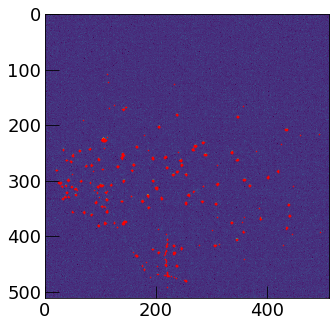

In [31]:
plt.imshow(rebin_image, vmin=-5, vmax=30)
ic = 0
yc = points[:,1][dbscan.labels_==ic]
xc = points[:,0][dbscan.labels_==ic]
plt.plot(yc,xc, 'r.', markersize=1)
plt.show()

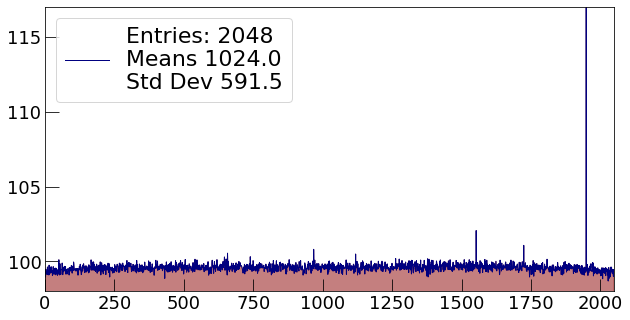

In [ ]:
# esmpio di plot con python
y = np.mean(image, axis=0) # proizione imagine lungo le y
fig, ax = plt.subplots(figsize=(10,5))
x = np.linspace(0, y.size, y.size)
ax.plot(x,y, "navy", label='Entries: {:d}\nMeans {:.1f}\nStd Dev {:.1f}'.format(x.size, x.mean(), x.std()))
ax.fill_between(x, 0, y, color='darkred', alpha=0.5)
ax.set_xlim(0, x_resolution)
ax.set_ylim(98, 117)
plt.legend()
plt.show()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


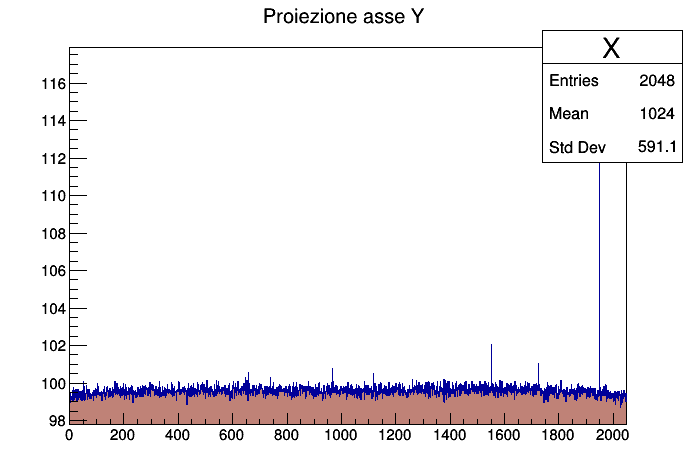

In [ ]:
# esempio equvalente di plot con ROOT
c2 = ROOT.TCanvas( 'c2', 'Dynamic Filling Example', 200, 10, 700, 500 )
c2.SetFillColor( 0 )
c2.GetFrame().SetFillColor( 0 )
c2.GetFrame().SetBorderSize( 6 )
c2.GetFrame().SetBorderMode( -1 )
h = ROOT.TH1F("X","Proiezione asse Y",np.size(x),np.min(x),np.max(x))
for i in range(np.size(y)):
   h.SetBinContent( i+1, y[i] )
#g = h.Fit( 'gaus')
#ROOT.gStyle.SetOptFit(1111)
h.Draw()
h.SetFillColor( 0 )
h.SetFillColor( 45 )
c2.Modified()
c2.Update()
c2.Draw()

 FCN=76.1323 FROM MIGRAD    STATUS=CONVERGED      60 CALLS          61 TOTAL
                     EDM=4.5787e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.59637e+02   2.79344e+00   9.75590e-03  -5.28711e-06
   2  Mean         6.45029e-03   1.41460e-02   6.06599e-05   4.63845e-04
   3  Sigma        9.85666e-01   1.01486e-02   1.19262e-05   5.40251e-03


Warning in <TCanvas::Constructor>: Deleting canvas with same name: myCanvasName


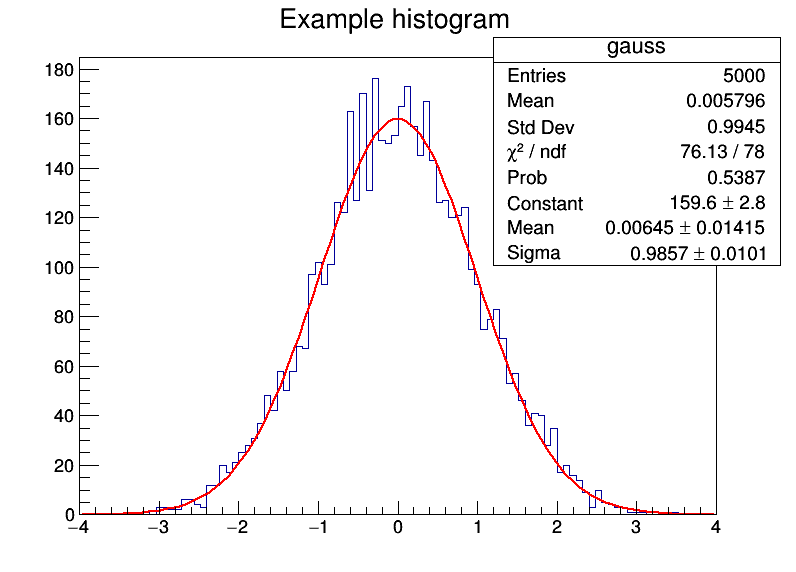

In [ ]:
# esempio di fit con ROOT
import ROOT
h1 = ROOT.TH1F("gauss","Example histogram",100,-4,4)
h1.FillRandom("gaus")
c = ROOT.TCanvas("myCanvasName","The Canvas Title",800,600)
g = h1.Fit( 'gaus')
ROOT.gStyle.SetOptFit(1111)
h1.Draw()
c.Draw()
# esempi vari qui... https://root.cern.ch/doc/master/group__tutorial__pyroot.html (io ROOT non lo bazzico molto)

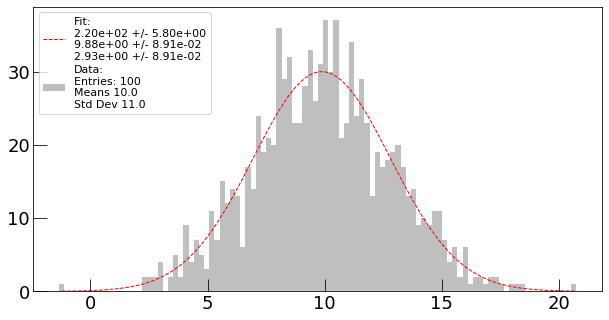

In [ ]:
# esempio di fit gaussiano con python
def gaussian(x, amp, cen, wid):
    "1-d gaussian: gaussian(x, amp, cen, wid)"
    return (amp/(np.sqrt(2*np.pi)*wid)) * np.exp(-(x-cen)**2 /(2*wid**2))

fig, ax = plt.subplots(figsize=(10,5))
data = np.random.normal(10,3,1000)
y, x = np.histogram(data, bins=100)
width=x[1]-x[0]
par, cov = curve_fit(gaussian, x[0:-1], y, p0=(y.max(), y.mean(), y.std()))
err = np.sqrt(np.diag(cov))
ax.bar(x[:-1], y, color='gray', width=width, alpha=0.5,
       label='Data:\nEntries: {:d}\nMeans {:.1f}\nStd Dev {:.1f}'.format(y.size, y.mean(), y.std()))
ax.plot(x[:-1], gaussian(x[0:-1], *par), 'r--', 
        label='Fit:\n'+', '.join(['{:.2e} +/- {:.2e}'.format(par[i], err[i]) for i in range(len(par))]).replace(', ','\n'))
plt.legend(loc=2, prop={'size': 11})
plt.show()